## Classification Metrics

### Table of Contents

* [Cross validation evaluation](#cv_evaluation)
* [Confusion matrix](#confusion_matrix)
* [Precision-Recall](#precision_recall)
* [ROC curve](#roc)

In [21]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# inline plot 
%matplotlib inline  
# default figure size 
matplotlib.rcParams['figure.figsize'] = (20, 10)
# to make our sets reproducible 
np.random.seed(42) 

In [22]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)


C:\Users\Or\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [23]:
mnist.data.shape

(70000, 784)

In [24]:
np.sqrt(784)

28.0

In [25]:
# import sklearn.datasets as datasets
# mnist = datasets.load_digits()
# X is 28x28 grayscale image (0-255)
X, y = mnist.data, mnist.target
# split 
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# reduce to binary classification for the digit 5
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [26]:
X.shape, y.shape

((70000, 784), (70000,))

In [27]:
num_samples, num_features = X_train.shape
print(f'''
Number of samples {num_samples}
Number of features {num_features}
''')


Number of samples 60000
Number of features 784



In [28]:
from sklearn.linear_model import SGDClassifier
# SVM classifier, default loss used is the hinge loss, less common to use today
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

### Cross validation evaluation <a class="anchor" id="cv_evaluation"></a>

In [29]:
from sklearn.model_selection import cross_val_score
cv_accuracy = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print(f'''cross validations accuracies: {cv_accuracy}''')

cross validations accuracies: [0.95035 0.96035 0.9604 ]


### Confusion_matrix <a class="anchor" id="confusion_matrix"></a>

In [30]:
# The data is split according to the cv parameter. 
# Each sample belongs to exactly one test set, and its prediction is computed 
# with an estimator fitted on the corresponding training set.
# Try not to use - only for the sake of example!!!
# the cross validation predict aggregates these predictions, 
# so each training sample is predicted by a model that did not see that sample during training.
from sklearn.model_selection import cross_val_predict

y_predictions = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="predict")

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_predictions)

# confusion matrix is of the form
# [[TN, FP],
#  [FN, TP]]

# TN - I predicted Negative and its True
# FP - I predicted Positive and its False
# FN - I predicted Negative and its False
# TP - I predicted Positive and its True

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

### Multiclass confusion matrix 

In [31]:
from sklearn.metrics import confusion_matrix
y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat", "tal"])

# Each row i represents the actual class i
# and each column j represents the predicted class j.
# For instance, 2 in (0,0) means that we predicted "ant" and it actually
# was ant, twice.
# 1 in (1,3) means that for one sample that was "bird", we predicted "cat".


array([[2, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 2, 0],
       [0, 0, 0, 0]], dtype=int64)

### Multilabel confusion matrix 

In [32]:
from  sklearn.metrics import multilabel_confusion_matrix

# Here, y_true and y_pred are numpy arrays where each row represents a sample, 
# and each column represents a class. 
# For instance, [0, 0] in y_true means the first sample does not belong to either 
# class 1 or class 2,
# and [1, 1] means the second sample belongs to both class 1 and class 2.

y_true = np.array([[0,0], [0,1], [1,1], [0,1], [0,1], [1,1]])
y_pred = np.array([[1,1], [0,1], [0,1], [1,0], [0,1], [1,1] ])
# generates confusion matrix per label
m = multilabel_confusion_matrix(y_true, y_pred)
print(f"""
confusion matrix for class 1: 
{m[0]}
confusion matrix for class 2: 
{m[1]}
""")

# The form of each confusion matrix is 
# [[TN, FP],
#  [FN, TP]]


confusion matrix for class 1: 
[[2 2]
 [1 1]]
confusion matrix for class 2: 
[[0 1]
 [1 4]]



## Precision - Recall <a class="anchor" id="precision_recall"></a>

In [33]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
y_true = [0, 1, 2, 0, 1, 2, 2]
y_pred = [1, 2, 1, 0, 1, 1, 2]

# 'micro':
# Calculate metrics globally by counting the total true positives,
# false negatives and false positives.
# 'macro':
# Calculate metrics for each label, and find their unweighted
# mean.  This does not take label imbalance into account.
precision_score(y_true, y_pred, average='macro')

0.5833333333333334

In [34]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[1, 1, 0],
       [0, 1, 1],
       [0, 2, 1]], dtype=int64)

In [35]:
# np.diag(cm)

In [36]:
# np.sum(cm, axis = 0)

In [37]:
# Explicit way to calculate 'macro'
cm = confusion_matrix(y_true, y_pred)
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
f1 = 2 * recall * precision / (recall + precision)
print(f"""
recall: {np.mean(recall)}
precision: {np.mean(precision)}
f1: {np.mean(f1)}
""")


recall: 0.4444444444444444
precision: 0.5833333333333334
f1: 0.4666666666666666



In [38]:
from sklearn.metrics import f1_score
y_true_b = [0, 1, 1, 0, 1, 0, 0]
y_pred_b = [0, 0, 1, 0, 0, 1, 0]

# How to calculate f1 for either Binary classification or Multiclass classification
print(f"""
binary: {f1_score(y_true_b, y_pred_b, average='binary')}
multiclass: {f1_score(y_true, y_pred, average='macro')}
""")


binary: 0.4
multiclass: 0.4666666666666666



### precision recall tradeoff

recall for 0.9 precision: 0.4799852425751706


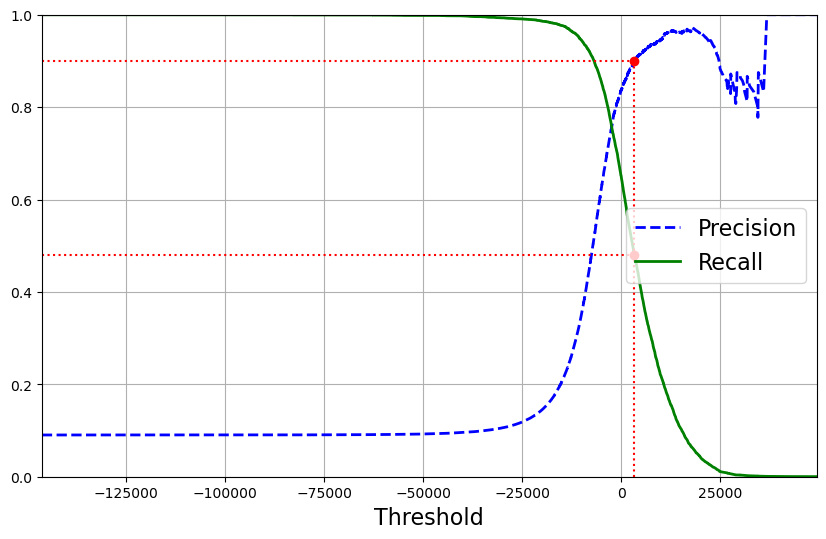

In [40]:
from sklearn.metrics import precision_recall_curve

# For each sample we calculate the distance of it from the separating hyperplane.
# Suppose that our sample is in the first fold, it means that the distance from the hyperplane
# was calculated according to the model that was trained on folds 2,3 and evaluated on fold 1,
# we got the hyperplane from this model

# method="predict_proba" for probabilities

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
# thresholds = thresholds used to obtain each precision recall score 
precisions, recalls, thresholds = precision_recall_curve(y_true=y_train_5, probas_pred=y_scores )

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([min(thresholds), max(thresholds), 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
print(f'recall for 0.9 precision: {recall_90_precision}')
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(10, 6))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
# plot the recall for the 0.9 precision
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([min(thresholds), threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([min(thresholds), threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                            
plt.show()

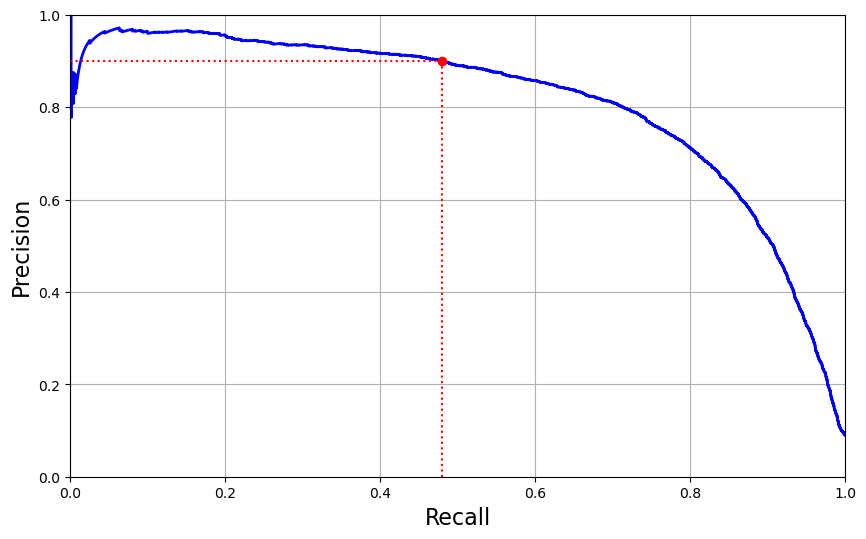

In [41]:
# For a decaying range of thresholds calculate the precision and recall and plot the
# precision in y-axis against the recall in x-axis

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(10, 6))
plot_precision_vs_recall(precisions, recalls)
# this is called recall@precision90
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

## ROC Curve <a class="anchor" id="roc"></a>

In [42]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

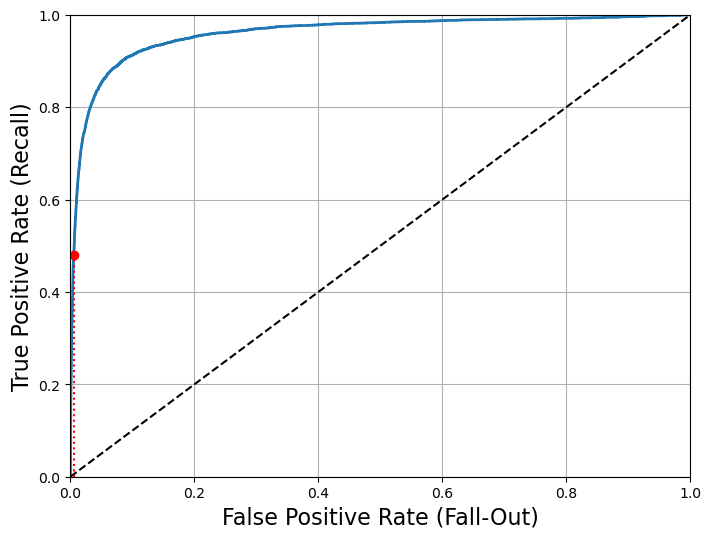

In [43]:

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
plt.show()